In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

# from image_classification_file import ImageFolderWithPathsAndRatings, ImageFolderWithPaths

In [2]:
"""
SCRIPT CLASSES
"""
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        # print(tuple_with_path)
        return tuple_with_path

class ImageFolderWithPathsAndRatings(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPathsAndRatings, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path
        # set rating
        try:
            tuple_with_path_and_rating = (tuple_with_path + (ratings[index],))
        except:
            tuple_with_path_and_rating = (tuple_with_path + (torch.FloatTensor([0]),))
        return tuple_with_path_and_rating

In [3]:
"""
SCRIPT GLOBAL VARS
"""
# root directory where the images are stored
data_dir = "/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump"#/Fall"#/Dump"
# ratings = None
limit_num_pictures = False #limit_num_pictures = 2000
rated_indices = []
ratings = []
bad_indices = []
# we load the pretrained model, the argument pretrained=True implies to load the ImageNet weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)

In [4]:
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
print("Head of indices: {}".format(indices[:10]))

split = int(np.floor(valid_size * num_pictures))
print("Split index: {}".format(split))

# may be unnecessary with the choice of sampler below
np.random.shuffle(indices)
print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split] #rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
            sampler=train_sampler, batch_size=1)#, num_workers=4)
print("Train loader length: {}".format(len(train_loader)))
test_loader = torch.utils.data.DataLoader(test_data,
            sampler=test_sampler, batch_size=1)#, num_workers=4)
print("Test loader length: {}".format(len(test_loader)))

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

vgg16.to(device) # loads the model onto the device (CPU or GPU)

Number of pictures in subdirectories: 69704
Head of indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Split index: 13940
Head of shuffled indices: [56735, 59746, 54458, 18998, 10694, 65779, 19922, 33089, 25957, 53182]
Size of training set: 55764, size of test set: 13940
Train loader length: 55764
Test loader length: 13940
Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 10)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

vgg16.load_state_dict(torch.load('models/Jan31_All_2017_Fall_Dump_only_labels_10scale_and_AVA.pt'))

<All keys matched successfully>


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_755.JPG
Classification for test image #0: [22615.4296875, -1247.3223876953125, -2312.472900390625, 868.13623046875, -1643.573974609375, -12208.56640625, 5096.77294921875, -8748.46484375, -3021.790283203125, 601.0797119140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


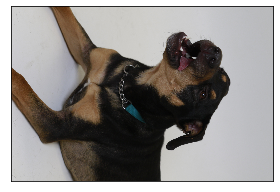


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_HickmanFBPractice_EJ/20170830_HickmanFBPractice_EJ_648.JPG
Classification for test image #1: [26006.08984375, 712.1573486328125, -1637.7236328125, 1375.85986328125, -2232.987548828125, -15319.7421875, -2909.81884765625, -7065.08935546875, 1839.8414306640625, -767.830810546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoccer_OL/20170831_HickmanSoccer_OL_286.JPG
Classification for test image #2: [14821.7548828125, -437.693115234375, -1624.3524169921875, 4036.520751953125, 3237.283203125, -6681.64892578125, -7894.66845703125, -3646.17431640625, 1181.3399658203125, -2992.865234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170827_unificasian_JJ/20170827_unificasi


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_storybookfarms_JJ/20170930_storybookfarms_JJ_176.JPG
Classification for test image #20: [9976.4775390625, -624.4078369140625, 2024.0633544921875, 4634.35205078125, 16193.935546875, -13231.193359375, -5952.103515625, -10447.5810546875, -282.53021240234375, -2292.96240234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


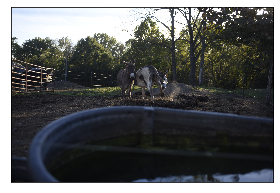


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171207_rbhoops_ec/20171207_rbhoops_ec_106.JPG
Classification for test image #21: [15006.0107421875, -292.39654541015625, -972.0714111328125, 7526.63818359375, 4105.947265625, -6490.35546875, -6078.6875, -8228.91015625, -2604.654296875, -1970.12890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171213_SturgeonFire_EJ/20171213_SturgeonFire_EJ_004.JPG
Classification for test image #22: [14952.2998046875, 752.254638671875, -5209.54248046875, 1357.5428466796875, 6846.685546875, -8243.986328125, -4575.05908203125, -5895.23095703125, -77.18983459472656, 92.02295684814453]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_865.JPG
Classification for test

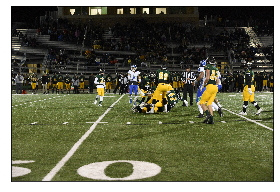


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170927_tuckerbattle_JJ/20170927_tuckerbattle_JJ_115.JPG
Classification for test image #41: [9085.5322265625, -572.6468505859375, -1916.955810546875, -887.291015625, 9918.3369140625, -9768.685546875, 2457.9248046875, -3738.35009765625, 795.6049194335938, -5372.890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ1205.JPG
Classification for test image #42: [21593.08984375, 383.0003662109375, -5547.74462890625, 7845.73193359375, 2746.23583984375, -14481.529296875, -2596.1142578125, -9235.267578125, 339.22998046875, -1046.5712890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0499.JPG
Classificat

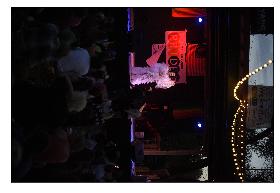


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171014_FlatbranchBrewVox_jd/20171013_FlatBranchBrewery_Vox_JD_012.JPG
Classification for test image #61: [13270.7724609375, -1743.7852783203125, -6827.31005859375, -573.134765625, 11865.779296875, -7225.5537109375, -1298.753173828125, -4811.42724609375, -488.42559814453125, -2166.88916015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_1820.JPG
Classification for test image #62: [16215.0810546875, -3883.12939453125, -445.6304931640625, 4506.146484375, 14626.404296875, -7943.4208984375, -9393.9326171875, -5216.59423828125, -2946.635986328125, -5518.04443359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171020_acaenrollment_JJ/20171020_


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstewartlate_JJ_240.JPG
Classification for test image #80: [30568.349609375, 1709.1173095703125, -2695.5107421875, 1867.96630859375, 782.721435546875, -17008.625, -3675.74267578125, -8463.91015625, -1546.4822998046875, -1536.3349609375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


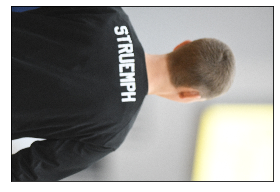


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_242.JPG
Classification for test image #81: [12207.203125, -191.6139373779297, -11692.033203125, 1201.018310546875, 15011.861328125, -1597.4248046875, -7880.97216796875, -5730.50146484375, -517.60205078125, -809.6671142578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_DDfarm_JJ/20170924_DDfarm_JJ_144.JPG
Classification for test image #82: [11151.5634765625, -911.5052490234375, -2650.078125, 8381.62890625, 8400.5068359375, -6332.51611328125, -12527.65234375, -1973.70166015625, 6.0091705322265625, -3544.03466796875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170922_battlefootball_Ec/20170922_fridaynightsights_ec_387.JPG
Classifi

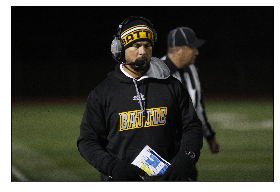


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonVolleyball_OL/20170906_ToltonVolleyball_OL_213.JPG
Classification for test image #101: [27997.314453125, 2778.243408203125, -923.096923828125, 11431.080078125, 6739.609375, -17405.728515625, -8876.921875, -16078.0625, -38.883819580078125, -5621.31982421875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_1070.JPG
Classification for test image #102: [14402.0205078125, -2778.970947265625, -6582.52783203125, 9654.4853515625, 21310.416015625, -17322.5078125, -7224.234375, -9547.59375, -2284.85205078125, 374.7772521972656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170901_VoxFall_JJ/20170901_VoxFall_JJ_153.JPG
Classification for test ima

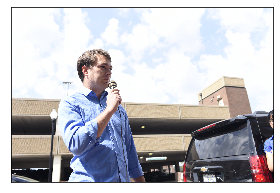


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltonsoftball_EJ_1020.JPG
Classification for test image #121: [18755.662109375, 1066.478759765625, -2141.335693359375, 8967.6357421875, 9937.40625, -19909.271484375, -7685.83935546875, -6422.0205078125, -388.02740478515625, -2179.658203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170823_BattleHSFootballPractice_jd/20170823_BattlefootballPractice_jd_0017.JPG
Classification for test image #122: [13021.6064453125, -213.5494384765625, -7744.234375, 2973.515380859375, 11303.421875, -11396.9296875, -1584.729248046875, -5923.83642578125, -134.5633087158203, -299.53424072265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_T


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_387.JPG
Classification for test image #140: [24806.81640625, -3181.8525390625, -9678.962890625, -1195.06103515625, 65.075927734375, -10234.373046875, 4151.25390625, -3441.57470703125, -361.4105529785156, -927.5111694335938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


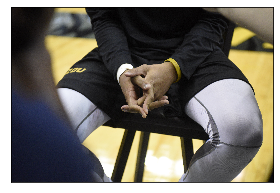


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170905_BattleTennisGirls_ec/20170905_battletennis_ec_102.JPG
Classification for test image #141: [25931.08984375, 700.8549194335938, -7323.29638671875, 696.93212890625, 3706.188720703125, -13052.669921875, -2267.275390625, -7536.85009765625, 1528.58251953125, -2383.01513671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170904_Feature_FamilyBBQ_jd/20170904_FeatureFamilyBBQ_jd_072.JPG
Classification for test image #142: [17500.08984375, -1258.2720947265625, -1786.56689453125, 10591.158203125, 16217.3046875, -16425.36328125, -15281.5732421875, -7169.34814453125, 985.0765991210938, -3371.982177734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonVolleyball_OL/20170906_Tolto


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_356.JPG
Classification for test image #160: [24279.2734375, -281.38226318359375, -10823.044921875, 3250.7275390625, -2221.738525390625, -7835.61572265625, -1934.6444091796875, -2589.08056640625, -974.9551391601562, -868.3809204101562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


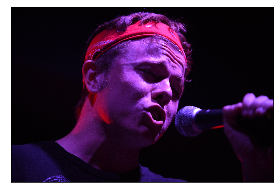


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170925_chip_nc/20170925_chip_nc_101.JPG
Classification for test image #161: [19706.48828125, -1234.5465087890625, -4960.3427734375, 2220.615478515625, -6187.650390625, -2872.542236328125, 692.9730224609375, -4983.28466796875, -1242.0460205078125, -1138.23828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170907_tomatofest_nc/20170907_tomatofestival_nc_337.JPG
Classification for test image #162: [20189.37109375, -4545.99951171875, -1987.39599609375, 2001.5537109375, -3624.021240234375, -2385.99658203125, -6411.9443359375, -4733.9765625, 1366.3721923828125, 132.391357421875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_180.JPG
Classification for tes


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_009.JPG
Classification for test image #180: [20764.9375, -2165.58935546875, -8099.24853515625, 6745.22900390625, 4274.70361328125, -10853.3671875, -3885.88427734375, -5607.001953125, -616.4320068359375, -556.1190185546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


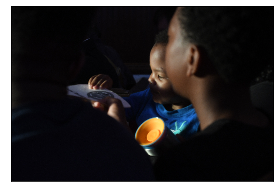


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171016_PeachTreeFarmsFH_EJ/20171016_PeachTreeFarmsFH_EJ_062.JPG
Classification for test image #181: [10317.1513671875, -1689.2200927734375, -5041.85888671875, 6420.91845703125, 19909.6796875, -14126.31640625, -82.0489501953125, -8339.8212890625, -1726.9617919921875, -5642.265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171002_mudvolleyball_jd/20171002CAFNRmudvolleyball_jd_172.JPG
Classification for test image #182: [22961.55078125, 1516.0804443359375, -2.5548248291015625, 10190.794921875, 1492.563720703125, -11969.05078125, -10670.1259765625, -8123.19189453125, -300.85333251953125, -5093.23486328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170906_MarchingMizzouVox_EJ/20170906_


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_188.JPG
Classification for test image #200: [10868.2470703125, -4413.12158203125, -2291.8349609375, 5115.8525390625, 8115.806640625, -3147.29833984375, -7820.03173828125, -5241.75927734375, -135.5712432861328, -1048.8455810546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


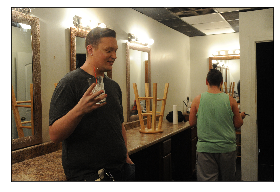


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170828_StephensVolleyball_jd/20170828_StephensVolleyball_jd_357.JPG
Classification for test image #201: [24798.12109375, -85.23069763183594, -5980.73291015625, 6944.69287109375, 5522.42431640625, -15303.236328125, -4251.25390625, -7460.3515625, -1029.5006103515625, -3153.10791015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_1132.JPG
Classification for test image #202: [12768.1982421875, -1946.3411865234375, -884.39453125, 5753.0224609375, 6215.8701171875, -3877.841796875, -8052.36474609375, -5596.94189453125, -1704.5078125, -2674.713134765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_07

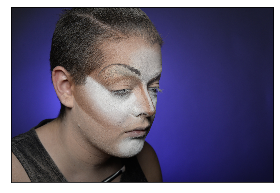


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_300.JPG
Classification for test image #221: [22250.271484375, 93.00923156738281, -8387.2705078125, -425.69384765625, 7204.7548828125, -5822.76416015625, -4743.42431640625, -7638.306640625, -154.01324462890625, -2375.4736328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170911_unitedwaydayofcaring_nc/20170911_unitedwaydayofcaring_nc_073.JPG
Classification for test image #222: [16000.47265625, -461.66253662109375, 1344.6988525390625, 3040.55615234375, 9787.193359375, -7202.1201171875, -11176.796875, -9019.2578125, -548.3327026367188, -1763.8101806640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootbal


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171105_skeetshoot_JJ/20171105_skeetshooting_JJ241.JPG
Classification for test image #240: [17114.49609375, -3254.99853515625, -8953.708984375, 701.37353515625, 5799.732421875, -7189.845703125, -2362.3251953125, -2551.9755859375, 835.007568359375, -134.80764770507812]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


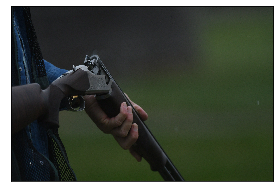


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_285.JPG
Classification for test image #241: [21306.7734375, -1083.3377685546875, -8705.435546875, 12145.4169921875, -7407.84765625, -7178.41015625, -1435.12109375, -4297.24560546875, -1932.23974609375, -1411.9901123046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170828_FeatureLeeStreetDeli/20170828_FeatureLeeStreetDeli_EJ_055.JPG
Classification for test image #242: [14968.546875, -529.0328369140625, -1579.130126953125, 6547.52734375, 10572.55859375, -10205.8671875, -12439.5751953125, -2705.0234375, -1470.6739501953125, -3158.32275390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171022_Voxcrockpot/20171022_voxcrockpot_JJ_1


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171023_HickmanSoccerTourn_jd/20171023_HickmanSoccer_JD_321.JPG
Classification for test image #260: [9292.9375, -747.9937133789062, -537.26904296875, 8387.2265625, 12559.3955078125, -13343.841796875, -5011.990234375, -6807.41845703125, 457.54931640625, -4248.24560546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


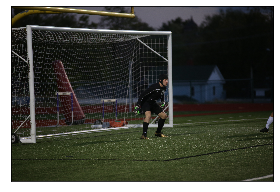


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171110_girlsbasketballshowcase_Ec/20171110_bballjambore_ec_266.JPG
Classification for test image #261: [18792.25390625, 1140.7261962890625, 2352.837890625, 5971.4072265625, 7572.294921875, -7960.26171875, -13778.796875, -6692.69384765625, 180.926025390625, -7577.51318359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170908_BooneFootball_OL/20170908_BooneFootball_OL_054.JPG
Classification for test image #262: [24407.27734375, -451.28082275390625, 807.2124633789062, 5776.8623046875, 3964.7255859375, -18352.25390625, -10543.869140625, -4480.34814453125, 1188.56298828125, -2316.66259765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_Boonevill


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0571.JPG
Classification for test image #280: [7812.47509765625, -2411.53955078125, -3178.658203125, -791.560791015625, 8208.5048828125, -13216.060546875, 7151.8671875, -1566.854736328125, -1355.972900390625, -652.3524780273438]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


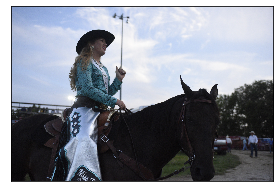


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170919_rbtennis_ec/20170919_rbtennis_Ec_ 115.JPG
Classification for test image #281: [16017.2548828125, 541.7849731445312, -2871.76806640625, 5743.8330078125, 11679.466796875, -8955.138671875, -7107.61279296875, -8647.5712890625, 83.72259521484375, -6483.671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170901_VoxFall_JJ/20170901_VoxFall_JJ_120.JPG
Classification for test image #282: [18109.021484375, -1221.8592529296875, -4147.35107421875, 2998.63037109375, 12014.0224609375, -22732.6875, -2341.79931640625, -2786.26708984375, 1854.1251220703125, -1744.875244140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170830_RockbridgeSoccer_jd/20170830_RockbridgeSoccer_jd_149.JPG
Classi

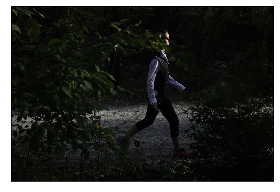


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonVolleyball_OL/20170906_ToltonVolleyball_OL_275.JPG
Classification for test image #301: [13179.2294921875, -2037.1221923828125, -9310.466796875, 5158.54296875, 1486.385498046875, -3290.592041015625, -5047.412109375, 2642.822265625, -344.915283203125, -2433.4833984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_313.JPG
Classification for test image #302: [22898.671875, 893.6383666992188, -3664.228515625, 5393.4521484375, -323.88330078125, -9242.1279296875, -7076.67236328125, -8392.7001953125, 2659.863525390625, -3147.970458984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171129_TaxProtest_EJ/20171129_TaxProte


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171011_AshleyCraftQA_Vox_EJ/20171011_AshleyCraftQA_EJ_014.JPG
Classification for test image #320: [17026.8828125, -1242.3555908203125, -5172.2197265625, 5902.33251953125, 1005.3865966796875, -2073.426513671875, -7268.66796875, -5710.80615234375, -1111.0638427734375, -1355.03662109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


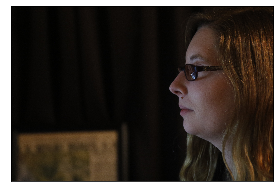


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_295.JPG
Classification for test image #321: [13155.0380859375, 1706.763916015625, -2179.825927734375, 1847.578125, 13004.6943359375, -10482.458984375, -2378.23828125, -9376.076171875, -1445.018798828125, -3851.857421875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170828_featurehunt_nc/20170828_featurehunt_nc_010.JPG
Classification for test image #322: [9614.0009765625, -1504.183349609375, -1074.7210693359375, 7416.966796875, 17062.462890625, -10409.5703125, -9215.0322265625, -5147.0732421875, -2057.56494140625, -4684.75244140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170908_BooneFootball_OL/20170908_BooneFootball_OL_539.JPG
Classification for


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0394.JPG
Classification for test image #340: [5332.6689453125, -3880.474365234375, -5966.68701171875, -419.955078125, 17136.412109375, -8481.529296875, 4070.21875, -6913.76025390625, -1089.91162109375, 212.2291259765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


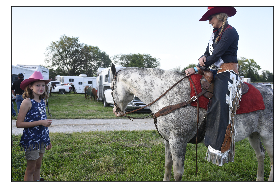


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171103_campuslivingplan_JJ/20171103_campuslivingplan_JJ_013.JPG
Classification for test image #341: [13050.0361328125, -2808.23291015625, -1651.28076171875, -4432.0302734375, 7522.5263671875, -6138.46875, -6271.625, 706.5595092773438, 80.91317749023438, -57.69112014770508]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171024_academyofrock_ec/20171024_academyofrock_ec_379.JPG
Classification for test image #342: [21975.837890625, -206.15367126464844, -7848.85302734375, 11103.4755859375, 6248.7265625, -9353.759765625, -9803.9033203125, -5417.51513671875, -3574.710693359375, -3122.837158203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170901_BattleRockbridgeFootball_OL/20170901_Battl


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171026_musoc_nc/20171026_musoc_nc_157.JPG
Classification for test image #360: [18815.46875, -890.5567016601562, -8194.3544921875, 13903.1669921875, -2811.852783203125, -11539.29296875, -6067.4873046875, -3726.063720703125, 1499.9300537109375, -989.2504272460938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


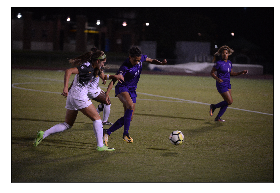


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_1348.JPG
Classification for test image #361: [17200.56640625, -2416.81640625, -2986.777099609375, 5066.13623046875, -1846.898681640625, -9171.71484375, -997.7730712890625, -4013.32177734375, 20.877727508544922, -855.9537963867188]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_showmestates_JJ/20170924_showmestates_JJ_033.JPG
Classification for test image #362: [25958.45703125, -1278.3203125, -5977.400390625, 5771.0693359375, 4538.65234375, -9458.904296875, -9795.72265625, -5555.28369140625, 442.7217102050781, -4646.5234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171117_logboat_nc/20171117_logboat_nc_218.JPG
Classification for

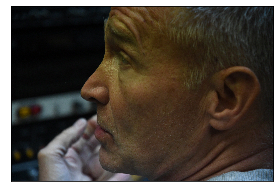


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoccer_OL/20170831_HickmanSoccer_OL_084.JPG
Classification for test image #381: [9689.5048828125, -986.9622802734375, -1622.308837890625, 13685.9033203125, 6954.7548828125, -6954.09130859375, -12133.1533203125, -5805.736328125, 488.924560546875, -3316.33837890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171009_PaigeBedsworth_EJ/20171009_PaigeBedsworth_EJ_831.JPG
Classification for test image #382: [10259.501953125, 532.8355102539062, -5420.4619140625, 5102.447265625, 10056.9609375, -9134.62890625, -3879.43603515625, -4724.09619140625, -421.07806396484375, -2373.078369140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170910_steamengineshow_jj/20170910_steamenginesho


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_hickmanvolleyball_nc/20170921_hickmanvolleyball_nc_049.JPG
Classification for test image #400: [26661.845703125, -315.9425048828125, -197.56492614746094, 1210.99169921875, 17336.400390625, -15133.345703125, -12711.7021484375, -12796.130859375, -419.7177429199219, -3632.980712890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


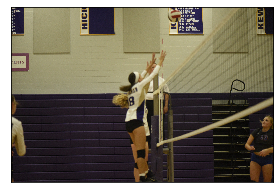


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_323.JPG
Classification for test image #401: [16200.134765625, -2738.919677734375, -4666.99609375, 6859.236328125, 9261.6650390625, -7749.7548828125, -8396.984375, -4550.38232421875, -2695.4873046875, -1522.568603515625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171210_starrpines_JJ/20171210_starrpines_JJ_029.JPG
Classification for test image #402: [11324.8427734375, 531.3508911132812, -5670.87744140625, 7350.64453125, 9666.736328125, -7527.95263671875, -7463.330078125, -5002.05126953125, -1494.6173095703125, -1714.5213623046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonFootballPractice_OL/20170906_ToltonFootballPractice

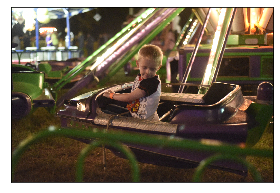


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSoccer_EJ_731.JPG
Classification for test image #421: [8086.60595703125, -42.27937316894531, -1258.919189453125, 8009.8017578125, 5853.73388671875, -13592.578125, -5241.0458984375, -971.2849731445312, 441.1363220214844, -1285.089599609375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170822_NAACPForum_EC/20170822_NAACPForum_EC_007.JPG
Classification for test image #422: [14043.3876953125, -3221.9853515625, -5818.52099609375, 2390.55517578125, 11097.0283203125, -4561.189453125, -3955.84619140625, -5496.1982421875, -1094.0899658203125, -3382.32470703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171207_rbhoops_ec/2017120


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170927_tuckerbattle_JJ/20170927_tuckerbattle_JJ_074.JPG
Classification for test image #440: [11131.4814453125, -431.504150390625, 2358.9326171875, 13077.6787109375, 9605.826171875, -16955.087890625, -9867.3359375, -4983.2705078125, 1151.756591796875, -5088.29052734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


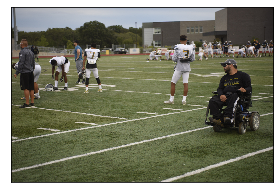


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171013_featurehunt_JJ/20171013_featurehunt_JJ_061.JPG
Classification for test image #441: [19521.287109375, -462.89434814453125, -1706.80126953125, 1822.46337890625, 7146.5380859375, -1959.6884765625, -14448.2021484375, -6739.32958984375, -1567.6546630859375, -1607.1046142578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170915_MUSoccer_OL/20170915_MUSoccer_OL_384.JPG
Classification for test image #442: [10279.0966796875, 155.04225158691406, -527.7550048828125, 12372.138671875, 14781.4384765625, -15609.9296875, -10552.642578125, -8079.7626953125, 653.6171875, -3470.495361328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171009_PaigeBedsworth_EJ/20171009_PaigeBedsworth_EJ_1295.JPG



Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_143.JPG
Classification for test image #460: [28352.10546875, -1186.4019775390625, -9198.001953125, 4360.447265625, 86.707763671875, -15346.25390625, -5418.2236328125, -3785.92333984375, 2161.48828125, -26.563194274902344]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


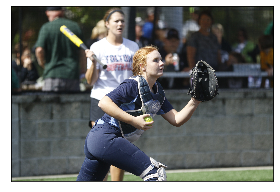


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensSoccer_OL_613.JPG
Classification for test image #461: [7782.20361328125, -62.189483642578125, -231.25413513183594, 6260.78125, 9609.4541015625, -13054.904296875, 1159.7784423828125, -6686.25048828125, -990.8557739257812, -3785.9921875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_790.JPG
Classification for test image #462: [13879.8564453125, 714.0638427734375, -1764.7894287109375, 7794.2919921875, 5903.408203125, -7001.35498046875, -9439.248046875, -7531.95166015625, 432.7074890136719, -2986.541748046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171201_VoxSpariver_JJ/20171201_Voxriversong_JJ_022.JPG
Clas

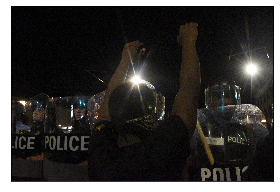


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170908_featurehunt_JJ/20170908_featurehunt_jj_155.JPG
Classification for test image #481: [14806.396484375, -2490.845703125, -2284.59765625, 14113.0712890625, 8010.7626953125, -11116.2265625, -9461.6005859375, -6281.580078125, 267.50396728515625, -5563.6875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171027_RockBridge_ec/20171027_rockbridge_Ec_0439.JPG
Classification for test image #482: [23306.48828125, -1930.3897705078125, -4485.72509765625, 5412.3984375, -952.336669921875, -7631.529296875, -5693.423828125, -6966.60693359375, 1158.1116943359375, -2218.690673828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170911_unitedwaydayofcaring_nc/20170911_unitedwaydayofcaring_nc_036.


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_2208.JPG
Classification for test image #500: [6460.74755859375, -2533.947265625, -578.4970092773438, 2048.545166015625, 7343.6220703125, -4331.373046875, -4533.9775390625, -1814.751220703125, -163.34994506835938, -1896.024169921875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


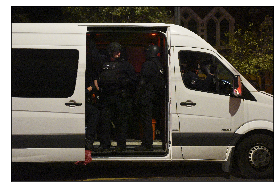


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/zz_Mugs/20170820_MissourianMugs_WM_271.JPG
Classification for test image #501: [19920.88671875, -738.6734008789062, -4036.58544921875, 2861.536376953125, 1143.361328125, -6645.3583984375, -5031.6337890625, -6310.3525390625, -1404.5216064453125, 242.14141845703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170827_unificasian_JJ/20170827_unificasian_JJ_157.JPG
Classification for test image #502: [14679.9326171875, 2346.660400390625, -6159.2548828125, 15491.0556640625, 9935.6728515625, -12513.013671875, -9790.931640625, -5404.51025390625, -1846.5582275390625, -6737.806640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170918_Hickmansoccer_jd/20170918HickmanSoccer_jd_056.JPG
Classification for test im

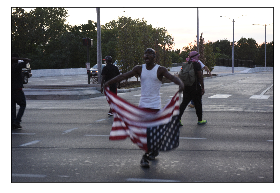


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171112_MUwrestling_JJ/20171112_MUwrestling_JJ_010.JPG
Classification for test image #521: [26359.53125, 516.1346435546875, -6095.54296875, 2132.198974609375, 1379.255615234375, -11662.78125, -3356.03076171875, -9486.591796875, 826.8067016601562, -612.7086791992188]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170821_Eclipse_jd/20170821_Eclipse_CoopersLanding_jd_457.JPG
Classification for test image #522: [13627.833984375, 346.48406982421875, -1436.5191650390625, -191.908935546875, 955.165283203125, -5122.98046875, -5963.1943359375, -1852.015869140625, -143.0520782470703, -218.94882202148438]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ521.J


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_993.JPG
Classification for test image #540: [23868.34375, -302.9718017578125, -6506.47021484375, 17106.6953125, 5011.076171875, -19280.072265625, -4416.60302734375, -11141.9453125, -1468.2064208984375, -2868.53955078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


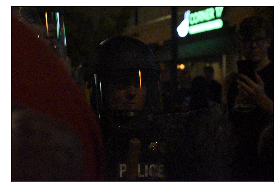


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_HickmanFBPractice_EJ/20170830_HickmanFBPractice_EJ_313.JPG
Classification for test image #541: [31055.0859375, -769.4683837890625, -10781.822265625, 1708.407470703125, -1710.705322265625, -6305.29541015625, 994.6690673828125, -13848.4296875, 1466.515380859375, -1809.0439453125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171020_acaenrollment_JJ/20171020_acaenrollment_JJ_036.JPG
Classification for test image #542: [30967.87890625, -1748.3846435546875, -11498.22265625, 1148.852783203125, 2899.238037109375, -11289.4169921875, 5673.5703125, -14004.017578125, 941.7730102539062, -3089.18017578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensS


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170908_BooneFootball_OL/20170908_BooneFootball_OL_471.JPG
Classification for test image #560: [16067.7578125, -518.968017578125, -3808.125, 4430.0107421875, 2962.513671875, -7529.86572265625, -7202.74609375, -1959.824462890625, -96.42994689941406, -2343.029296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


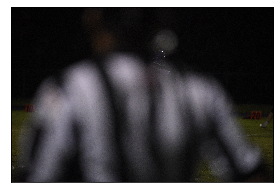


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ844.JPG
Classification for test image #561: [16669.482421875, -4.8132171630859375, -6983.80615234375, -5038.3076171875, -3848.607666015625, -2651.78564453125, 3841.01806640625, -4340.23876953125, 1463.990478515625, 892.625244140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_storybookfarms_JJ/20170930_storybookfarms_JJ_081.JPG
Classification for test image #562: [16336.2900390625, -521.6556396484375, -2090.330078125, 5767.63427734375, -3896.662353515625, -8114.9794921875, 2647.81640625, -8018.19384765625, 44.712425231933594, -2153.75244140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170906_StephensSoccer_jd/20170906_StephensSoc

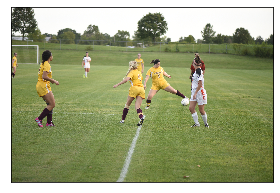


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_261.JPG
Classification for test image #581: [17331.1640625, 783.67431640625, -4499.12939453125, 6501.14892578125, 2829.06640625, -11594.0068359375, -3721.70947265625, -7746.115234375, 730.7102661132812, -613.4318237304688]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_DouglassSisters_EJ/20170830_DouglassSisters_EJ_190.JPG
Classification for test image #582: [11780.2099609375, -642.7072143554688, -3316.10400390625, 179.96142578125, 8597.314453125, -5076.451171875, -8494.84375, -2824.54052734375, -580.5938110351562, 378.3599548339844]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensSoccer_OL_563.JPG


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170911_HickmanVolleyball_jd/20170911_HickmanVolleyball_jd_256.JPG
Classification for test image #600: [25557.005859375, 141.1496124267578, 369.445068359375, -473.88232421875, 2947.183837890625, -8209.6875, -8882.1201171875, -9941.5751953125, -1242.987548828125, -263.31280517578125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


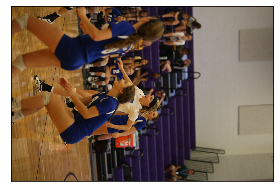


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_273.JPG
Classification for test image #601: [12383.732421875, 695.8453369140625, -806.7352294921875, 494.614990234375, 4447.6328125, -5727.5361328125, -10501.341796875, 166.51275634765625, 1229.958251953125, -2382.651611328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170821_EclipseI70_EJ/20170821_EclipseI70_EJ_043.JPG
Classification for test image #602: [22756.857421875, -3715.220703125, -6586.36767578125, 4332.78955078125, 9270.927734375, -10943.5546875, -8261.7978515625, -8118.306640625, 765.0702514648438, 500.97283935546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_quidditch_JJ/20170930_quidditch_JJ_116.JPG
Classification for t

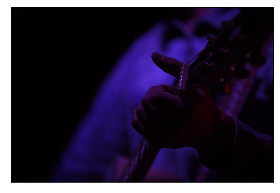


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171027_BattleFB_FNS_EJ/20171027_BattleFB_FNS_EJ_581.JPG
Classification for test image #621: [27341.4765625, -1360.0794677734375, -12315.2666015625, 8924.4638671875, -8723.712890625, -6448.75537109375, 5362.7158203125, -11661.06640625, -716.60498046875, -402.085693359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0067.JPG
Classification for test image #622: [2998.7861328125, -3022.80615234375, -1649.9521484375, 6321.9189453125, 25903.361328125, -11806.7060546875, -9915.7958984375, -2539.22412109375, -1676.439453125, -4613.4130859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSocc


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstewartlate_JJ_031.JPG
Classification for test image #640: [24039.875, -1567.983154296875, -2809.53076171875, 2219.006103515625, -381.992431640625, -11499.0810546875, -3653.78369140625, -1784.34375, -1149.1964111328125, -3411.2001953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


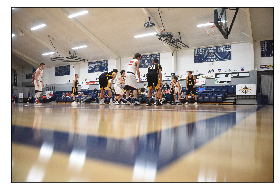


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_542.JPG
Classification for test image #641: [34595.7421875, 3600.368408203125, -7477.93115234375, 1819.9130859375, 2603.52978515625, -15036.166015625, -13028.4931640625, -5897.82080078125, 159.5146484375, -1338.3626708984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171208_oaklandpaper_JJ/20171208_oaklandpaper_JJ_066.JPG
Classification for test image #642: [21953.41015625, -340.80169677734375, -9965.443359375, 2104.57373046875, 2266.77685546875, -12065.30859375, -1018.9902954101562, -4152.7451171875, 1247.300048828125, -26.80474090576172]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170918HickmanSoftball_jd/20170918HickmanSoftball_jd_122


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_008.JPG
Classification for test image #660: [14898.2626953125, -2367.14306640625, 1074.1827392578125, -1017.2548828125, 9314.494140625, -9440.6171875, -4542.62353515625, -3967.76953125, -1526.5858154296875, -2424.1748046875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


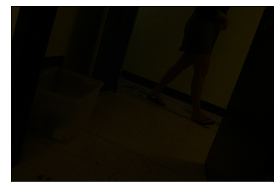


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170903_horseshoe_JJ/20170903_Horseshoe_JJ_078.JPG
Classification for test image #661: [20045.810546875, -2965.66552734375, -9173.25390625, 10227.287109375, 16759.025390625, -19252.654296875, -12272.8330078125, -4102.58349609375, 1563.9097900390625, -829.92626953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoftball_OL/20170831_HickmanSoccer_OL_286.JPG
Classification for test image #662: [25310.8046875, 432.67401123046875, -9137.2685546875, 1278.01904296875, -5914.4130859375, -9576.04296875, 1631.6685791015625, -5288.45947265625, 1234.025634765625, 29.18561553955078]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170829_ShermanHighway_ec/20170829_shermanhighway_ec_053


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_1028.JPG
Classification for test image #680: [11410.7880859375, -1047.023681640625, -768.5442504882812, 11705.21484375, 18140.283203125, -15251.9609375, -14252.0517578125, -4114.14501953125, -856.2796630859375, -4965.54052734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


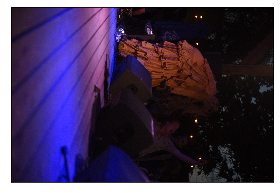


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171001GourdWorkshop_jd/20171001_artworkshop_jd_085.JPG
Classification for test image #681: [24263.31640625, 713.8953247070312, -4520.12939453125, 6387.35302734375, 3148.386474609375, -13781.162109375, -6700.9111328125, -6158.96533203125, 212.0920867919922, -3562.971435546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/zz_Mugs/20170820_MissourianMugs_WM_195.JPG
Classification for test image #682: [18736.24609375, -569.1788330078125, -7005.15771484375, 968.1712646484375, -6617.2412109375, 145.7216796875, -3813.23583984375, -2844.145751953125, 177.12350463867188, 822.4506225585938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_461.JPG
Classification for test 

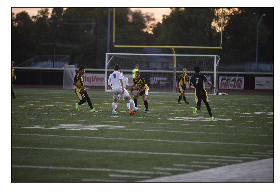


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171027_BattleFB_FNS_EJ/20171027_BattleFB_FNS_EJ_262.JPG
Classification for test image #701: [26759.083984375, -2.4898529052734375, -8603.5419921875, 9486.775390625, -3547.318603515625, -7431.8740234375, -9271.673828125, -6933.04150390625, 930.9730834960938, -1387.725830078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171021_madness_nc/20171021_madness_nc_076.JPG
Classification for test image #702: [24343.255859375, 1960.279541015625, -5011.05029296875, 4859.830078125, 8906.5302734375, -10022.30859375, -15981.37109375, -9680.6689453125, 875.2389526367188, -249.11004638671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170919_rbvolleyball_ec/20170919_rbvolleyball_Ec_ 283.JPG
Cl

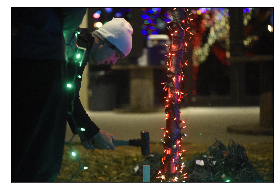


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_DDfarm_JJ/20170924_DDfarm_JJ_117.JPG
Classification for test image #721: [21835.279296875, -771.3568115234375, -7757.86328125, -7230.1279296875, 9839.7529296875, -8593.0546875, -1075.740966796875, -5037.8037109375, -471.20465087890625, -738.9529418945312]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltonsoftball_EJ_521.JPG
Classification for test image #722: [18368.4453125, -275.4271240234375, -3343.938720703125, 269.8094482421875, 1102.171875, -9636.5732421875, 4892.609375, -7834.37744140625, -1450.930908203125, -2089.619384765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_271.JPG
Classification for 

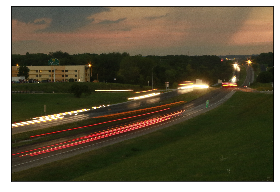


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171101_VoxRadioArchives_EJ/20171101_VoxRadioArchive_EJ_141.JPG
Classification for test image #741: [12793.4892578125, -1777.2044677734375, 625.9229125976562, -2128.8525390625, 370.24560546875, 181.85791015625, -2240.25537109375, -3728.4501953125, -783.9393310546875, -3310.928466796875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170901_VoxFall_JJ/20170901_VoxFall_JJ_057.JPG
Classification for test image #742: [16058.6787109375, -1071.179443359375, 941.432373046875, 5072.1318359375, 223.09375, -6623.5390625, -7905.0712890625, -4956.34423828125, -1006.35400390625, -732.4203491210938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170919_rbvolleyball_ec/20170919_rbvolleyball_Ec_ 022.

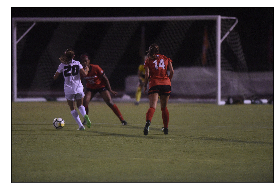


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCelebration_EJ/20171209_KwanzaaCelebration_EJ_137.JPG
Classification for test image #761: [16332.1484375, -2402.18212890625, -3157.494873046875, -72.11962890625, 4705.2685546875, -5580.99658203125, -6660.6025390625, -1476.9638671875, 285.68597412109375, -1971.9132080078125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_030.JPG
Classification for test image #762: [27518.8984375, 3868.624755859375, -4554.23291015625, 4382.79248046875, 14090.65234375, -19743.6171875, -5007.39599609375, -16046.431640625, 953.3115234375, -5462.81640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCol


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_002.JPG
Classification for test image #780: [12661.9033203125, 104.24269104003906, -2449.159423828125, 6509.20361328125, 9515.017578125, -10163.513671875, -6066.53369140625, -4226.646484375, -1341.836181640625, -4541.9423828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


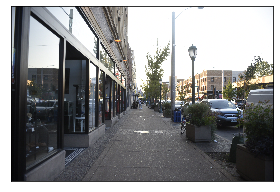


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171015_featurehunt_JJ/20171015_featurehunt_JJ_063.JPG
Classification for test image #781: [13214.9755859375, -2185.4833984375, -1374.613525390625, 1859.2801513671875, 3986.65869140625, -2661.08544921875, -3569.423828125, -5052.20556640625, -1692.759765625, -2524.913818359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170907_tomatofest_nc/20170907_tomatofestival_nc_334.JPG
Classification for test image #782: [19747.1015625, -4983.57568359375, -1624.826416015625, 437.9920654296875, -3214.849853515625, -3517.354248046875, -6031.83056640625, -2952.04443359375, 1460.3197021484375, 680.0735473632812]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170827_unificasian_JJ/20170827_unificasian

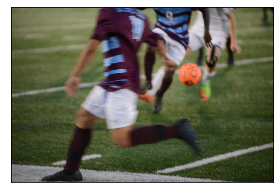


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_501.JPG
Classification for test image #801: [8800.6923828125, 475.7808837890625, -1210.1497802734375, 1051.3349609375, 14431.34765625, -10543.431640625, -7817.4677734375, 101.42205810546875, -1154.19189453125, -4136.224609375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonVolleyball_OL/20170906_ToltonVolleyball_OL_745.JPG
Classification for test image #802: [52862.73828125, 3573.8359375, -3397.22412109375, 5110.755859375, 11552.3671875, -19524.255859375, -22720.56640625, -19956.65234375, -925.681396484375, -6573.51953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ311.JPG
Classification for t

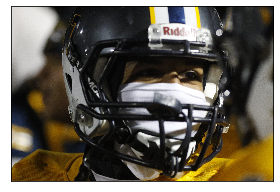


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170908_featurehunt_JJ/20170908_featurehunt_jj_169.JPG
Classification for test image #821: [17249.48046875, -1871.864501953125, -5152.5185546875, 2204.53662109375, 14995.2294921875, -17308.4453125, -4080.46142578125, -1776.72509765625, -944.7080688476562, -3313.734130859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171103_VOXcomics_JJ/20171103_VOXcomics_JJ_010.JPG
Classification for test image #822: [18612.4921875, 2471.77587890625, 2884.672607421875, 8813.626953125, 4995.63427734375, -15635.712890625, -9130.4375, -7222.478515625, -3985.5009765625, -1804.5755615234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171018_DerbyRidgePieAssembly_EJ/20171018_DerbyRidgePieAssembly_EJ_0


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170913_DreamersSolidarityDay_EJ/20170913_DreamersSolidarityDay_EJ_054.JPG
Classification for test image #840: [18989.69921875, 20.947219848632812, -6038.0224609375, 5458.30419921875, -2932.444580078125, -7858.8671875, -1572.2659912109375, -4329.0078125, -401.9565124511719, -1335.30810546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


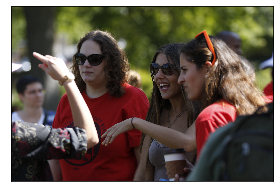


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171021_madness_nc/20171021_madness_nc_129.JPG
Classification for test image #841: [23540.10546875, 405.152587890625, -12761.408203125, -2401.12451171875, 119.775390625, 2577.93408203125, -10448.2333984375, -5793.0849609375, 2455.1142578125, 2305.880615234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170830_RockbridgeSoccer_jd/20170830_RockbridgeSoccer_jd_302.JPG
Classification for test image #842: [12024.4208984375, 159.30845642089844, -2687.94140625, 10603.0087890625, 13012.83984375, -8903.595703125, -11211.32421875, -7827.16552734375, 997.6048583984375, -6165.87451171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171004_healthcoaches_EJ/20171004_HealthCoaches_EJ_098.JPG
Classifi


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170823_gradrally_EJ/20170823_gradrally_EJ174.JPG
Classification for test image #860: [15334.9091796875, -1244.9085693359375, -2005.060546875, -2599.8681640625, 819.197509765625, -8023.02001953125, 757.6832275390625, -5726.28271484375, 554.6912231445312, 2132.5146484375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


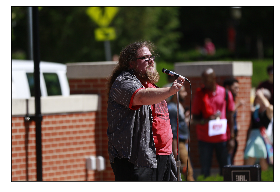


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170906_CartwrightPresser_EJ/20170906_CartwrightPresser_EJ_068.JPG
Classification for test image #861: [19067.779296875, -468.41656494140625, -9613.5947265625, -1705.92236328125, 11471.337890625, -10046.732421875, -1108.3797607421875, -5906.28076171875, -383.26763916015625, -1304.5152587890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170830_HickmanFBPractice_EJ/20170830_HickmanFBPractice_EJ_160.JPG
Classification for test image #862: [22809.28515625, -1423.7548828125, -7320.60791015625, 10502.810546875, 7533.0615234375, -14743.14453125, -12007.6650390625, -6269.50830078125, 1495.9761962890625, -576.2232055664062]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFo


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_528.JPG
Classification for test image #880: [11438.5078125, -690.45947265625, -6552.95068359375, 8740.759765625, 4657.0244140625, -8998.3544921875, -5154.9306640625, -918.7874145507812, -1139.662353515625, -1380.3995361328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


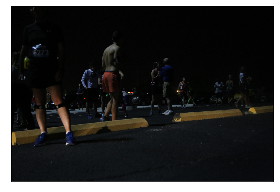


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_673.JPG
Classification for test image #881: [20995.796875, 204.57179260253906, -6836.62890625, 5955.7138671875, -6076.9658203125, -6926.38671875, -6215.861328125, -1750.4775390625, 911.7540283203125, -261.64581298828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171025_Rockclimbing_ec/20171025_rockclimbing_341.JPG
Classification for test image #882: [18043.056640625, -1398.0631103515625, -6944.99609375, -431.298095703125, -2172.825439453125, -7657.98828125, 1968.7818603515625, -529.8302001953125, -1210.8267822265625, 334.6062927246094]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/20170


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170830_Trump_EC/20170830_Trump_EC_719.JPG
Classification for test image #900: [12992.4228515625, -3801.75634765625, -4827.29443359375, -10680.8427734375, 10921.009765625, -2213.8837890625, 3024.6826171875, -2135.19189453125, -1315.6597900390625, -1961.379638671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


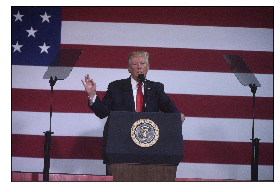


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171026_accident_nc/20171026_accident_nc_120.JPG
Classification for test image #901: [19081.783203125, -933.3414916992188, -2566.519287109375, 7349.83154296875, 5376.1298828125, -12698.416015625, -5300.9208984375, -9356.08203125, -508.78167724609375, -444.0932312011719]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170823_BattleHSFootballPractice_jd/20170823_BattlefootballPractice_jd_0139.JPG
Classification for test image #902: [19457.19140625, 539.4410400390625, -6402.4013671875, -3577.9677734375, -570.675048828125, -6311.3994140625, -2638.91650390625, -1811.55712890625, 1048.1986083984375, 269.42694091796875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/zz_Mugs/20170820_MissourianMugs_WM_049.JPG
Classifi

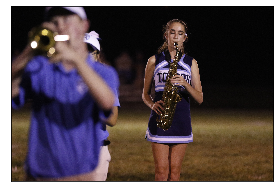


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170901_BattleRockbridgeFootball_OL/20170901_BattleRockbridgeFootball_OL_695.JPG
Classification for test image #921: [19828.59375, -1229.3839111328125, -3793.7451171875, 11962.2998046875, -4761.3916015625, -3791.104248046875, -5474.9033203125, -9783.6513671875, 207.7750701904297, -3163.620361328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSoccer_EJ_628.JPG
Classification for test image #922: [17199.322265625, 913.3395385742188, -2273.076171875, 4809.8203125, 9250.7646484375, -15410.482421875, -5886.84814453125, -8809.099609375, 1135.2994384765625, -928.8995971679688]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoccer


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_1131.JPG
Classification for test image #940: [10317.6337890625, -1133.023681640625, -3734.6923828125, 7103.6181640625, 6251.4794921875, -5570.49267578125, -3270.16015625, -5419.80517578125, -1697.1597900390625, -2846.5927734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


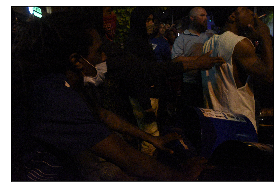


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171110_girlsbasketballshowcase_Ec/20171110_bballjambore_ec_195.JPG
Classification for test image #941: [40558.7578125, -702.1941528320312, -3564.6396484375, 107.238525390625, 2885.446044921875, -13279.466796875, -13521.2109375, -9976.689453125, -68.56053161621094, -2437.504638671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171112_Bethelchoir_JJ/20171112_bethelchoir_JJ_025.JPG
Classification for test image #942: [13567.2041015625, -1530.688720703125, 1442.154052734375, 7508.56787109375, -1367.0224609375, -8872.25, -3117.04248046875, -5029.5771484375, -571.8904418945312, -2027.6502685546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltons


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170915_stlouisprotest_ec/20170915_STLOUISPROTEST_ec_052.JPG
Classification for test image #960: [13160.9306640625, -1117.4808349609375, -6880.06201171875, -2537.99462890625, 12517.1376953125, -1535.654541015625, -6018.3818359375, -4075.444091796875, -181.6954345703125, -3331.140380859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


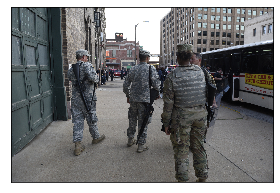


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0259.JPG
Classification for test image #961: [15033.5615234375, -98.02088928222656, -275.653076171875, -91.501953125, -1240.364990234375, -590.7060546875, -10214.1220703125, -1591.034423828125, -193.78468322753906, -736.4595947265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_428.JPG
Classification for test image #962: [19765.611328125, -1961.9180908203125, -9511.43359375, 4888.01416015625, 2514.2890625, -7004.205078125, -6823.96484375, -1279.43798828125, -575.5923461914062, -9.345352172851562]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170914_democracyplay_nc/20170914_democracyplay_nc_249

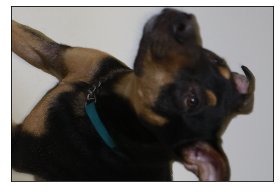


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171002_visitingartist_nc/20171002_visitingartist_nc_125.JPG
Classification for test image #981: [11190.8828125, -919.8151245117188, -1453.43408203125, 4451.732421875, 8181.990234375, -2534.1943359375, -5952.4443359375, -7371.9443359375, -979.9042358398438, -4612.236328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonVolleyball_OL/20170906_ToltonVolleyball_OL_572.JPG
Classification for test image #982: [25131.82421875, -2575.3544921875, -4566.25732421875, 8665.193359375, -6216.50390625, -10628.580078125, -2891.5703125, -8257.939453125, -804.9771728515625, 2145.660400390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_1197.JPG



Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_1004.JPG
Classification for test image #1000: [10704.3818359375, -2027.1424560546875, -6948.56689453125, 12328.5556640625, 16120.9931640625, -16888.08203125, -3776.744140625, -7358.15380859375, -1960.4674072265625, -195.50311279296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


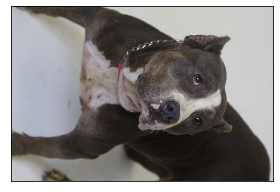


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_327.JPG
Classification for test image #1001: [14978.2060546875, 2055.2236328125, -3688.7392578125, 11180.0595703125, -1819.344970703125, 1014.72119140625, -11219.48046875, -8818.078125, 170.19984436035156, -3852.127685546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_238.JPG
Classification for test image #1002: [32213.8984375, 4459.82177734375, -4212.37060546875, 14266.4931640625, 8176.841796875, -19381.58203125, -13535.8173828125, -17250.90625, 1898.2587890625, -6633.88427734375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_214

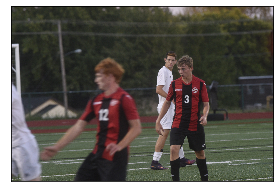


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170901_VoxFall_JJ/20170901_VoxFall_JJ_174.JPG
Classification for test image #1021: [15532.2470703125, -1705.698974609375, -4138.595703125, 5228.138671875, 3561.365966796875, -10486.09375, -1890.3818359375, -6024.98291015625, -423.0556640625, 348.6715087890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171008_crushfestival_JJ/20171008_crushfestival_JJ_536.JPG
Classification for test image #1022: [17814.60546875, -1211.9832763671875, -2333.892333984375, 8181.7646484375, -4016.086181640625, -3885.34130859375, -3425.19482421875, -6576.46337890625, -389.4379577636719, -4159.42138671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_StephensSoccer_OL_100.J


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170922_battlefootball_Ec/20170922_fridaynightsights_ec_112.JPG
Classification for test image #1040: [24997.203125, -1715.302978515625, -1468.083251953125, 985.35205078125, 3380.557861328125, -14972.529296875, -8328.744140625, -4185.22314453125, 1918.435791015625, -612.580322265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


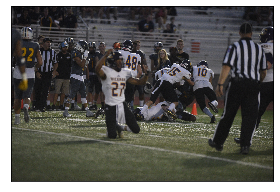


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_869.JPG
Classification for test image #1041: [8491.9482421875, -2041.0064697265625, -4516.17431640625, 17523.8984375, 22142.392578125, -14516.16796875, -7800.966796875, -13541.822265625, 108.90852355957031, -5850.94384765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171108_HickmanWrestling_EJ/20171108_HickmanWrestling_EJ_209.JPG
Classification for test image #1042: [17394.509765625, -472.71429443359375, -8202.9296875, 4656.5546875, -3939.730712890625, -3842.7333984375, 640.3875732421875, -4736.6572265625, -822.666259765625, -673.471435546875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171023_Citizenjane_nc/20171023_citizenjane_n


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170825_Pitbulls_EJ/20170825_voxPitbulls_EJ_878.JPG
Classification for test image #1060: [20222.072265625, -4130.3173828125, -7240.96826171875, 19661.0390625, 9947.8037109375, -17179.107421875, -11617.6376953125, -9795.8271484375, -395.2754821777344, 527.498779296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


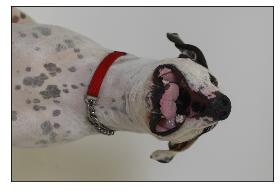


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171027_BattleFB_FNS_EJ/20171027_BattleFB_FNS_EJ_194.JPG
Classification for test image #1061: [22921.12890625, 1808.916015625, -7191.10107421875, 10033.087890625, 60.048095703125, -13053.486328125, -2096.865478515625, -10442.4970703125, -588.3863525390625, -1450.504638671875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171102_VOXgrannybasketball_JJ/20171102_VOXgrannybasketball_JJ_123.JPG
Classification for test image #1062: [20723.24609375, -308.39605712890625, -4347.72265625, -2013.796875, 7454.3828125, -4254.9150390625, -10956.087890625, -6567.27001953125, 1251.5455322265625, -980.5875854492188]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171117_logboat_nc/20171117_logboat_nc_119.J


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171203_nightbball_JJ/20171203_normstewartlate_JJ_531.JPG
Classification for test image #1080: [15263.912109375, 357.03973388671875, 1053.186279296875, 648.023681640625, 7.909423828125, -5988.7119140625, -5752.15185546875, -2488.431640625, 469.34796142578125, -3568.39404296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


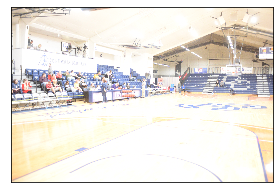


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_349.JPG
Classification for test image #1081: [27604.810546875, -1401.3121337890625, -3659.896484375, 9935.6181640625, 7814.4052734375, -13776.90234375, -14210.3896484375, -9226.8046875, 557.819091796875, -3635.18798828125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171002_toltonsoftball_EJ/20171002_toltonsoftball_EJ_012.JPG
Classification for test image #1082: [11868.8466796875, 930.2832641601562, -2133.00390625, 7378.79248046875, 5361.4130859375, -10509.5615234375, -7231.7841796875, -4627.4267578125, 372.66326904296875, -1410.3360595703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_702.JPG
Cla

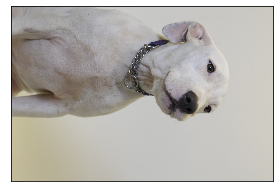


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_040.JPG
Classification for test image #1101: [17718.4140625, 648.0865478515625, -4858.517578125, 6701.158203125, 430.064208984375, -15296.869140625, -4789.90966796875, -2782.244140625, 2222.4970703125, 6.976844787597656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171016_PeachTreeFarmsFH_EJ/20171016_PeachTreeFarmsFH_EJ_054.JPG
Classification for test image #1102: [5233.34765625, -1823.4593505859375, -5192.0009765625, -1126.521484375, 28118.513671875, -11893.603515625, -920.2423095703125, -7882.51513671875, -1190.6580810546875, -3323.900390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170902_MissouriHorseshoe_JJ/20170902_MissouriHorseshoe_JJ_114.JPG
Classification for test image #1120: [15853.1552734375, -2705.206787109375, -9659.515625, 1798.5609130859375, 11734.412109375, -7626.91357421875, -10265.642578125, 261.40802001953125, 615.0313720703125, -4.920280456542969]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


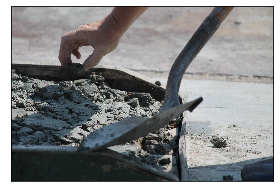


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170911_unitedwaydayofcaring_nc/20170911_unitedwaydayofcaring_nc_185.JPG
Classification for test image #1121: [14611.7275390625, -248.59144592285156, -266.6627197265625, 8408.373046875, 3558.3671875, -13104.84765625, -3518.2021484375, -5440.59765625, -2676.1552734375, -1324.6783447265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_1444.JPG
Classification for test image #1122: [15438.7060546875, 293.31024169921875, 3557.4677734375, 8147.86962890625, 8293.9775390625, -7645.65771484375, -10479.2470703125, -10846.126953125, -1290.59619140625, -5469.66064453125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170919_rbvolleyball_ec/20170919_rbvolleyball_Ec_ 520.JPG
Classification for test image #1140: [22119.0703125, 1233.7186279296875, -1119.40771484375, 14870.6884765625, 8549.802734375, -16395.27734375, -11986.7880859375, -12219.416015625, -84.79768371582031, -4966.17333984375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


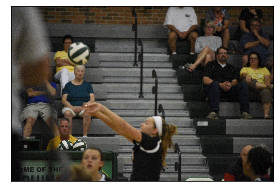


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170904_HeartofAmericaMarathon_EJ/20170904_HeartofAmericaMarathon_EJ_485.JPG
Classification for test image #1141: [12776.0791015625, -2883.681396484375, -6736.81640625, 4976.8330078125, 8159.08984375, -8210.376953125, -2302.27099609375, -2713.015625, -1707.3916015625, -1357.505126953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170905_BattleTennisGirls_ec/20170905_battletennis_ec_077.JPG
Classification for test image #1142: [18727.5078125, 249.03663635253906, -5879.5390625, 3475.13232421875, 988.7225341796875, -6931.71875, -6361.09033203125, -3982.73095703125, 1417.5032958984375, -1701.725341796875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170830_StephensSoccor_OL/20170830_Ste

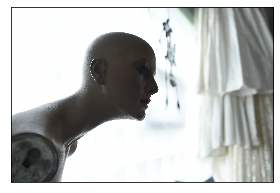


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170901_BattleRockbridgeFootball_OL/20170901_BattleRockbridgeFootball_OL_568.JPG
Classification for test image #1161: [24946.33984375, -248.57347106933594, -1836.390380859375, 9165.1494140625, 4807.3544921875, -12283.888671875, -11730.6005859375, -8944.5771484375, -229.93360900878906, -3644.85693359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_DDfarm_JJ/20170924_DDfarm_JJ_140.JPG
Classification for test image #1162: [6030.0, -2480.9033203125, -1769.0849609375, 8780.328125, 14485.091796875, -5710.5751953125, -9264.5029296875, -5139.12109375, -1618.826171875, -3312.121337890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171108_PoachingStory_EJ/20171108_PoachingStory_EJ_108.JP


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170828_StephensVolleyball_jd/20170828_StephensVolleyball_jd_233.JPG
Classification for test image #1180: [37562.453125, -683.3198852539062, -419.73095703125, 3142.814453125, 4130.7548828125, -10742.306640625, -19657.396484375, -8780.8603515625, -578.2883911132812, -3973.340576171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


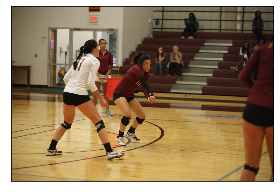


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170901_musoc_ec/20170901_musoc_Ec_165.JPG
Classification for test image #1181: [10221.0419921875, 606.030029296875, -2947.349365234375, 7147.53759765625, 5811.2099609375, -10473.568359375, -5697.2109375, -4490.13525390625, 465.9500732421875, -643.1781616210938]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_074.JPG
Classification for test image #1182: [11765.7646484375, -206.28721618652344, -2616.435546875, 9957.486328125, 3058.868896484375, -8206.4619140625, -7089.27978515625, -6088.67138671875, 1482.4075927734375, -2056.67822265625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171002_visitingartist_nc/20171002_visitinga


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_864.JPG
Classification for test image #1200: [12729.685546875, -501.5684814453125, 2430.5546875, 6636.4169921875, 7276.9453125, -11755.685546875, -6749.1259765625, -5686.42626953125, -1602.132080078125, -2777.15576171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


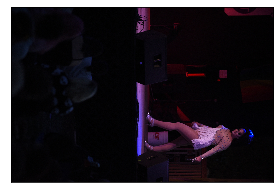


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170823_BattleSoftball_OL/20170823_Battlesoftball_OL_160.JPG
Classification for test image #1201: [24540.669921875, -460.13470458984375, -9426.990234375, 6592.595703125, -5629.275390625, -15649.095703125, 3830.20166015625, -2501.258544921875, 1736.63623046875, -3033.216796875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ246.JPG
Classification for test image #1202: [43618.68359375, -3504.291748046875, -21841.953125, 15975.255859375, -12021.478515625, -12356.48046875, -3654.841796875, -12362.0966796875, 3069.489501953125, 3078.326904296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/20171028_StephensCollegeSocce


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170906_StephensSoccer_jd/20170906_StephensSoccer_JD_116.JPG
Classification for test image #1220: [17405.779296875, -2119.409912109375, -8266.974609375, 6871.87548828125, 4503.814453125, -13126.505859375, -4927.37548828125, -1316.502685546875, 989.3822631835938, -14.221733093261719]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


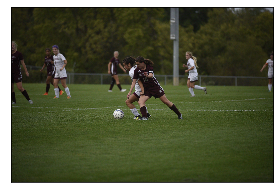


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170921_mktbridges_nc/20170921_mktbridges_nc_101.JPG
Classification for test image #1221: [15077.2529296875, 48.63825988769531, -4553.041015625, 4707.73388671875, 7522.87890625, -15320.03125, -3725.1162109375, -549.2656860351562, -1423.4853515625, -1784.154541015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170930_girlswhogame_JJ/20170930_girlswhogame_JJ_098.JPG
Classification for test image #1222: [21802.6640625, -173.18101501464844, -2868.211181640625, 12735.20703125, 13882.9140625, -20856.384765625, -12381.0078125, -4694.84619140625, -484.8168029785156, -6960.2666015625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171002_mudvolleyball_jd/20171002CAFNRmudvolleyball_jd_067.JPG
Clas

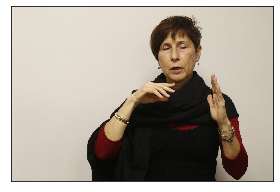


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171009_PaigeBedsworth_EJ/20171009_PaigeBedsworth_EJ_867.JPG
Classification for test image #1241: [9539.7578125, -109.31205749511719, -3066.4697265625, 9467.759765625, 5808.5224609375, -9843.26171875, -2697.58740234375, -6949.38916015625, -788.318115234375, -1362.6219482421875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171101_VoxRadioArchives_EJ/20171101_VoxRadioArchive_EJ_291.JPG
Classification for test image #1242: [17922.943359375, -578.010498046875, 27.634780883789062, 5594.66943359375, 5714.248046875, -13491.64453125, -4636.63525390625, -4019.806396484375, -1965.3309326171875, -4565.4765625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_259


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171112_MUwrestling_JJ/20171112_MUwrestling_JJ_145.JPG
Classification for test image #1260: [26988.7265625, -353.169189453125, -16465.1953125, 5284.96875, -1136.462158203125, -11216.890625, 2662.953125, -9150.951171875, 328.9703674316406, 3059.49365234375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


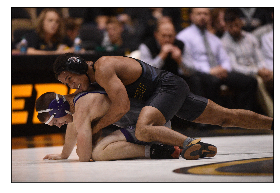


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20170823_PreFootballFeature/20170823_prefootballfeature_jd_0022.JPG
Classification for test image #1261: [10929.1083984375, -1323.1846923828125, -5038.1845703125, -2002.65625, 16362.95703125, -10477.37890625, -2630.98876953125, -3282.173828125, -789.223388671875, -1748.52587890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171008_crushfestival_JJ/20171008_crushfestival_JJ_138.JPG
Classification for test image #1262: [17553.375, -3238.14306640625, -9835.98046875, 4429.712890625, 3089.122314453125, -10769.8515625, 754.0679931640625, -2546.259521484375, -214.59300231933594, 779.0379028320312]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171113_christmasstores_nc/20171113_christmasstores_n

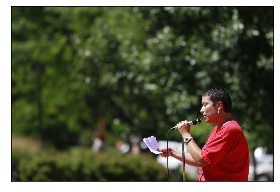


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171116_muwbb_Ec/20171116_muwbb_ec_674.JPG
Classification for test image #1281: [36952.22265625, 908.0433349609375, -6845.515625, 7093.626953125, -3143.064208984375, -11192.912109375, -10379.5244140625, -12074.7421875, 1299.201416015625, -2617.5654296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170922_RockBridgeFootball_OL/20170922_RockbridgeFootball_OL_526.JPG
Classification for test image #1282: [19319.07421875, 3774.98583984375, 1847.4957275390625, 9988.1943359375, 7434.53515625, -11169.3623046875, -15566.6162109375, -7231.7353515625, -2293.009033203125, -6103.18603515625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170922_hookah_JJ/20170922_hookah_JJ_040.JPG
Classification 

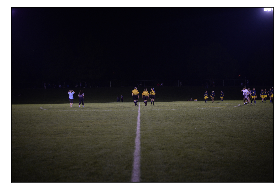


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171019_battlesoccer_nc/20171019_battlesoccer_nc_001.JPG
Classification for test image #1301: [6462.443359375, -1470.0814208984375, -4965.55419921875, 11660.4580078125, 5605.314453125, -7596.92431640625, -4701.93505859375, -5445.83740234375, 1337.581298828125, -885.269287109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170907_ShawnVeronika_OL/20170907_ShawnVeronica_OL_395.JPG
Classification for test image #1302: [17489.05078125, 502.42230224609375, -6199.71826171875, 4980.232421875, 4047.5712890625, -11351.1259765625, -5936.33447265625, -2520.21484375, -932.4000854492188, -77.65453338623047]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170919_rbvolleyball_ec/20170919_rbvolleyball_E

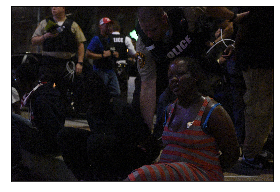


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170922_ToltonFNSfb_EJ/20170922_ToltonFNSfb_EJ976.JPG
Classification for test image #1321: [18553.1875, -1338.9969482421875, -7807.03564453125, 8225.0869140625, -1341.615478515625, -8369.51171875, -4858.955078125, -4658.56494140625, 1752.4072265625, -156.80520629882812]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_058.JPG
Classification for test image #1322: [24693.1328125, -1534.2982177734375, -6558.68896484375, -5081.1005859375, 22.535400390625, -3010.244384765625, -2038.36669921875, -7837.6484375, 258.1001281738281, 1087.3753662109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171108_HickmanWrestling_EJ/20171108_HickmanWrestling_EJ_008.J


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170901_BattleRockbridgeFootball_OL/20170901_BattleRockbridgeFootball_OL_400.JPG
Classification for test image #1340: [15018.7412109375, -1574.0069580078125, -6183.1748046875, 9544.607421875, 12310.08203125, -14364.291015625, -7167.15576171875, -5369.42724609375, 469.6033935546875, -2684.61474609375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


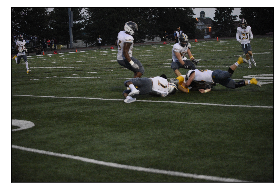


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171102_VOXgrannybasketball_JJ/20171102_VOXgrannybasketball_JJ_065.JPG
Classification for test image #1341: [29568.77734375, -481.9559326171875, -6562.84033203125, -4195.57958984375, 16942.6953125, -3161.707763671875, -17935.37890625, -14295.392578125, 25.569820404052734, 97.14627838134766]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170823_BattleSoftball_OL/20170823_Battlesoftball_OL_806.JPG
Classification for test image #1342: [17728.8359375, -2842.28369140625, -12650.68359375, 2993.66064453125, 7976.7919921875, -15838.41796875, -2135.42822265625, 465.0008544921875, 2368.275634765625, 1933.231201171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171009_voxeateryart2_nc/20171009_voxea


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171008_crushfestival_JJ/20171008_crushfestival_JJ_158.JPG
Classification for test image #1360: [14446.205078125, -1561.1634521484375, -8631.06640625, -1881.2841796875, 5878.0927734375, -8353.650390625, 2046.6353759765625, -3978.2763671875, 1367.9373779296875, 667.340087890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


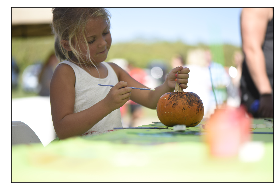


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170906_ToltonFootballPractice_OL/20170906_ToltonFootballPractice_OL_059.JPG
Classification for test image #1361: [9213.2119140625, -1091.1632080078125, 792.1461181640625, 6699.92578125, 4752.763671875, -10014.486328125, -8445.6474609375, -2372.71484375, 200.77017211914062, 265.6527404785156]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171202_toltongbb_NC/20171202_gbb_nc_120.JPG
Classification for test image #1362: [26098.36328125, -1332.6507568359375, -542.474853515625, -724.530029296875, 9008.5625, -15879.869140625, -7428.8271484375, -9555.662109375, 977.0447998046875, -619.0919799804688]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170910_defenddaca_JJ/20170910_defenddaca_jj_121.JPG
C


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170920_MUVolleyball_OL/20170920_MUVolleyball_OL_464.JPG
Classification for test image #1380: [26058.31640625, 2338.20751953125, -6008.7138671875, 15585.7470703125, -3182.318115234375, -12151.95703125, -8535.8818359375, -12958.818359375, 819.1439208984375, -1964.0211181640625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


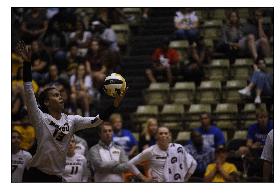


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20170821_EclipseI70_EJ/20170821_EclipseI70_EJ_143.JPG
Classification for test image #1381: [19974.326171875, -2484.730224609375, -2066.317626953125, 3666.61328125, 12062.4482421875, -13792.56640625, -8221.134765625, -5560.81787109375, -1628.833251953125, -1947.037109375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170914_usscolumbia_nc/20170914_usscolumbia_nc_044.JPG
Classification for test image #1382: [20305.0234375, 95.19071960449219, -7046.84423828125, 274.8095703125, 1001.8148193359375, -6882.5341796875, -7346.203125, -557.2485961914062, 1376.906982421875, -1219.509521484375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170825_Rodeo_Ashland_ec/20170825_rodeo_EC_0054.JPG
Classif


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_022.JPG
Classification for test image #1400: [16858.41015625, -2321.8388671875, -4755.6240234375, -4020.4150390625, 6009.251953125, -5178.0986328125, -1839.3438720703125, -4869.99267578125, 286.837890625, -169.1150360107422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


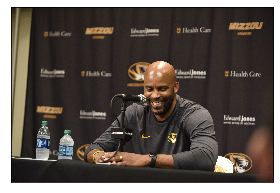


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170826_PrideFest_OL/20170826_PrideFest_OL_884.JPG
Classification for test image #1401: [14899.921875, -1598.3714599609375, 200.12159729003906, 7951.8095703125, 10625.427734375, -11038.57421875, -10165.6279296875, -7700.41796875, -1123.05419921875, -2049.623779296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170824_stephenssoccer_NC/20170824_stephenssoccer_nc_435.JPG
Classification for test image #1402: [13502.8662109375, -417.193603515625, 650.123046875, 5458.4619140625, 6096.29296875, -14383.548828125, -2334.625, -6337.36767578125, -371.3695068359375, -1863.6876220703125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170831_HickmanSoccer_OL/20170831_HickmanSoccer_OL_321.JPG
Classificatio

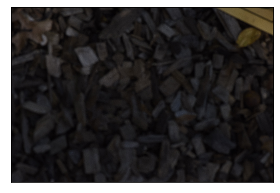


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170908_BooneFootball_OL/20170908_BooneFootball_OL_329.JPG
Classification for test image #1421: [18757.775390625, -719.2205200195312, -3759.04345703125, 3833.825439453125, -2857.349365234375, -6039.96142578125, -4345.37646484375, -3904.928955078125, 810.4741821289062, -1778.1585693359375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171022_Voxcrockpot/20171022_voxcrockpot_JJ_097.JPG
Classification for test image #1422: [17688.4296875, -1105.9844970703125, -4589.9912109375, 12649.1474609375, 12576.7431640625, -16999.44921875, -10243.0478515625, -7227.71337890625, 28.01061248779297, -2776.020751953125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171013_helicoptertraining_JJ/20171013_heli


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171006_intellectualproperty_JJ/20171006_intellectualproperty_JJ_027.JPG
Classification for test image #1440: [11431.0927734375, -2713.80126953125, -612.855224609375, 3361.163330078125, 11137.103515625, -1164.39306640625, -11389.6728515625, -4858.14599609375, -932.4019775390625, -4257.06494140625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


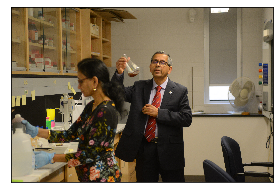


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_148.JPG
Classification for test image #1441: [19889.6171875, -1168.9578857421875, -2916.90673828125, 12789.81640625, 4672.3095703125, -13643.45703125, -9801.4638671875, -8037.69970703125, 56.11799240112305, -1840.092529296875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Dodge, Jessi/20171001GourdWorkshop_jd/20171001_artworkshop_jd_050.JPG
Classification for test image #1442: [21671.74609375, -2331.552001953125, -285.90301513671875, 8594.35546875, -5063.7509765625, -12001.673828125, -6584.9384765625, -3032.334228515625, 1149.1744384765625, -2115.105712890625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171128_hickmanwrestling_ec/20171128_hickmanwre


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171007_toltonsoftball_EJ/20171007_toltonsoftball_EJ_681.JPG
Classification for test image #1460: [14647.4267578125, -279.33709716796875, -2447.09326171875, 7175.8955078125, -3761.576416015625, -2799.40185546875, -5077.96728515625, -5643.1865234375, 329.0074157714844, -2143.4736328125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


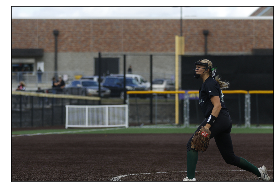


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170914_hickmanvrockbridgesoftball_nc/20170914_hickmanvrockbridgesoftball_nc_106.JPG
Classification for test image #1461: [15901.564453125, -376.17877197265625, -2744.3134765625, -2921.51904296875, 2425.472900390625, -7640.42626953125, -730.8531494140625, -3817.83154296875, 1925.1700439453125, -2021.9150390625]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171026_musoc_nc/20171026_musoc_nc_019.JPG
Classification for test image #1462: [14978.072265625, 145.9282989501953, -1089.464599609375, 8478.0322265625, 3166.6025390625, -8275.220703125, -9889.0400390625, -4361.57470703125, 1134.13427734375, -4286.46826171875]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171028_StephensCollegeSoccer_EJ/

In [ ]:
limit_num_pictures = 2500
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, _ = data
    path = path[0]
#     label = torch.LongTensor([int(label[0])])

    output = vgg16(inputs)
#     loss = criterion(output, label)

#     running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
#     num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
    print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(8):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 200 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

# testing_loss = running_loss/len(test_loader.dataset)
# testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')


In [ ]:
# ratings_data.set_index('file_path')
ratings_data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
space_1 = scaler.fit_transform(ratings_data)
ratings_data_norm = pd.DataFrame(space_1, columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

In [ ]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

In [ ]:
ratings_data_norm

In [ ]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head(25).index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head(25).index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()